In [1]:
# from autocvd import autocvd
# autocvd(num_gpus = 1)
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["JAX_PLATFORMS"] = "cpu"

import numpy as np
import matplotlib.pyplot as plt

import jax.random as jr

from unxt import Quantity
import galax.coordinates as gc
import galax.potential as gp
import galax.dynamics as gd

import agama

import time


In [2]:
import tensorflow_probability
tensorflow_probability.__version__  # to silence pycharm warning

'0.25.0'

In [3]:
import equinox
equinox.__version__  # to silence pycharm warning

'0.13.2'

The first run is slow. This is a feature of JIT.
/export/home/vgiusepp/Odisseo/notebooks/dev/albastross/action_angle/galax/src/galax/dynamics/_src/legacy/mockstream/df/chen24.py:53: RuntimeWarning: Currently only the "no progenitor" version of the Chen+24 model is supported!
  warnings.warn(

Elapsed time: 8.773148775100708 seconds
The second run should be much faster.
/export/home/vgiusepp/Odisseo/notebooks/dev/albastross/action_angle/galax/src/galax/dynamics/_src/legacy/mockstream/df/chen24.py:53: RuntimeWarning: Currently only the "no progenitor" version of the Chen+24 model is supported!
  warnings.warn(

Elapsed time: 0.00429534912109375 seconds


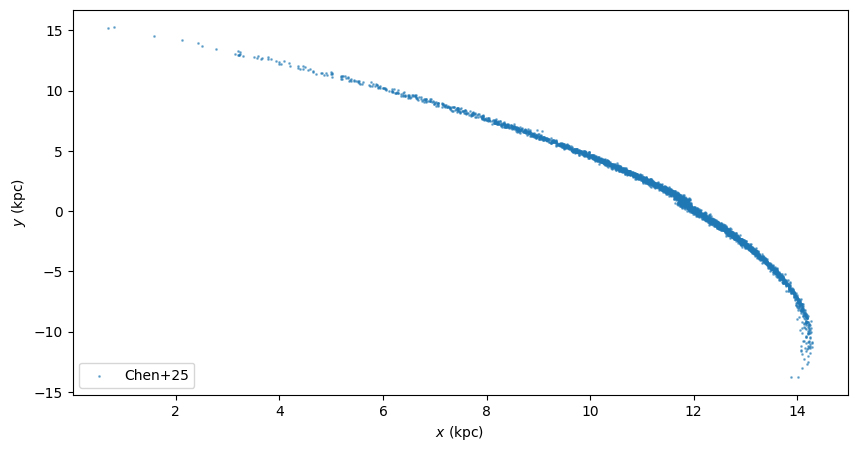

In [ ]:
pot = gp.BovyMWPotential2014()

w = gc.PhaseSpacePosition(q=Quantity([11.8, 0.79, 6.4], "kpc"),
                            p=Quantity([109.5,-254.5,-90.3], "km/s"),
                        )

t_array = Quantity(-np.linspace(0, 3000, 2000), "Myr")
prog_mass = Quantity(10**4.5, "Msun")
print("The first run is slow. This is a feature of JIT.")

# Chen+25 (no prog.)
df = gd.ChenStreamDF()
gen = gd.MockStreamGenerator(df, pot)
start = time.time()
gen.run(jr.key(0), t_array, w, prog_mass)
end = time.time()
print(f"Elapsed time: {end - start} seconds")

print("The second run should be much faster.")

# Chen+25 (no prog.)
df = gd.ChenStreamDF()
gen = gd.MockStreamGenerator(df, pot)
start = time.time()
gen.run(jr.key(0), t_array, w, prog_mass)
end = time.time()
print(f"Elapsed time: {end - start} seconds")

fig = plt.figure(figsize=(10, 5))
stream_c25, prog_c25 = gen.run(jr.key(0), t_array, w, prog_mass)
plt.scatter(stream_c25.q.x.value, stream_c25.q.y.value, s=1, label="Chen+25", alpha=0.5)
plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.legend(loc='lower left')
# plt.savefig('./plot/particlespray_chen25/stream_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def stream_to_numpyarray(stream):
    pos = np.array([stream.q.x.to('kpc'), stream.q.y.to('kpc'), stream.q.z.to('kpc')]) * u.kpc
    vel = np.array([stream.p.x.to('km/s'), stream.p.y.to('km/s'), stream.p.z.to('km/s')]) * u.km / u.s
    return pos, vel

def stream_to_cylindrical(stream_pos, stream_vel):
    R = np.sqrt(stream_pos[0]**2 + stream_pos[1]**2)
    phi = np.arctan2(stream_pos[1], stream_pos[0])
    z = stream_pos[2]

    vR = (stream_vel[0]*stream_pos[0] + stream_vel[1]*stream_pos[1]) / R
    vT = (stream_vel[1]*stream_pos[0] - stream_vel[0]*stream_pos[1]) / R
    vz = stream_vel[2]

    stream_cyl_pos = np.array([R, phi, z])
    stream_cyl_vel = np.array([vR, vT, vz])
    return np.array([R, vR, vT, z, vz, phi])

stream_array_pos, stream_array_vel = stream_to_numpyarray(stream_c25)
stream_cyl = stream_to_cylindrical(stream_array_pos, stream_array_vel)


# Stackel Fudge

In [12]:
from gala.dynamics.actionangle import get_staeckel_fudge_delta
from galpy.actionAngle import actionAngleStaeckel
from galpy.potential import MWPotential2014
import gala.dynamics as gala_gd
import gala.integrate as gala_gi
import gala.potential as gala_gp
from gala.units import galactic
import astropy.units as u

w0 = gala_gd.PhaseSpacePosition(pos=stream_array_pos * u.kpc, 
                                    vel=stream_array_vel * u.km/u.s)
pot = gala_gp.MilkyWayPotential()
galpy_potential = pot.as_interop("galpy")
orbits = pot.integrate_orbit(
    w0, dt=0.5, n_steps=20000)
galpy_potential = pot.as_interop("galpy")
J = np.zeros((3, orbits.norbits))
Omega = np.zeros((3, orbits.norbits))
for n, orbit in enumerate(orbits.orbit_gen()): 
    o = orbit.to_galpy_orbit()
    delta = get_staeckel_fudge_delta(pot, orbit)
    staeckel = actionAngleStaeckel(pot=galpy_potential, delta=delta)
    af = staeckel.actionsFreqs(o)
    af = np.mean(np.stack(af), axis=1)
    J[:3, n] = af[:3]
    Omega[:3, n] = af[3:]

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:163: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  name = pos.__class__.get_name()



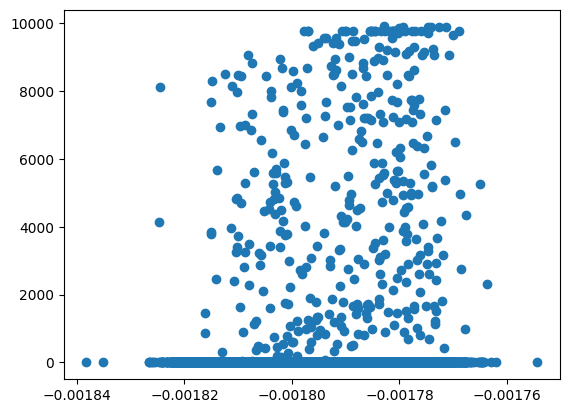

In [13]:
plt.scatter(J[1], J[0])

# AvGF 

In [ ]:
from galpy.actionAngle import actionAngleIsochroneApprox, estimateBIsochrone
from galpy.potential import MWPotential2014
from astropy import units as u

def stream_to_numpyarray(stream):
    pos = np.array([stream.q.x.to('kpc'), stream.q.y.to('kpc'), stream.q.z.to('kpc')]) * u.kpc
    vel = np.array([stream.p.x.to('km/s'), stream.p.y.to('km/s'), stream.p.z.to('km/s')]) * u.km / u.s
    return pos, vel

def stream_to_cylindrical(stream_pos, stream_vel):
    R = np.sqrt(stream_pos[0]**2 + stream_pos[1]**2)
    phi = np.arctan2(stream_pos[1], stream_pos[0])
    z = stream_pos[2]

    vR = (stream_vel[0]*stream_pos[0] + stream_vel[1]*stream_pos[1]) / R
    vT = (stream_vel[1]*stream_pos[0] - stream_vel[0]*stream_pos[1]) / R
    vz = stream_vel[2]

    stream_cyl_pos = np.array([R, phi, z])
    stream_cyl_vel = np.array([vR, vT, vz])
    return np.array([R, vR, vT, z, vz, phi])

stream_array_pos, stream_array_vel = stream_to_numpyarray(stream_c25)
stream_cyl = stream_to_cylindrical(stream_array_pos, stream_array_vel)


pot = MWPotential2014
b = estimateBIsochrone(pot, R=stream_cyl[:, 0], z=stream_cyl[:, 3])
aAIA = actionAngleIsochroneApprox(pot=pot, b=b[1])

actions_freq_angles = aAIA._actionsFreqsAngles(*stream_cyl)  # to silence pycharm warning

KeyboardInterrupt: Orbit integration interrupted by CTRL-C (SIGINT)